# **Step 1: Import Libraries**

In [34]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Import Standard Libraries
import os
import zipfile

# Import Machine Learning Libraries
import torch
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from glob import glob

# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow
import tensorflow as tf

**Set Seed for Reproducibility**

In [36]:
# Set Seed for Reproducibility
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# **Step 2: Load Data**

In [37]:
# Define Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Function to Extract ZIP File
def extract_data(zip_path, extracted_path):
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract Data
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 3: Data Preprocessing**

In [38]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Load Labels CSV
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')
labels_df = pd.read_csv(labels_csv_path)

# Initialize One-Hot Encoding Columns
for disease in disease_labels:
    labels_df[disease] = 0

# Vectorized One-Hot Encoding
for disease in disease_labels:
    labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

# Handle 'No Finding'
labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

# Split Multiple Labels into Lists
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda s: [label.strip() for label in s.split('|')])

# Map Image Index to Paths
num_glob = glob(os.path.join(EXTRACTED_PATH, '**', 'images', '*.png'), recursive=True)
img_path_dict = {os.path.basename(x): x for x in num_glob}

# Assign Paths to Labels DataFrame
labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)

# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Patients**

Number of Unique Patients: 30805


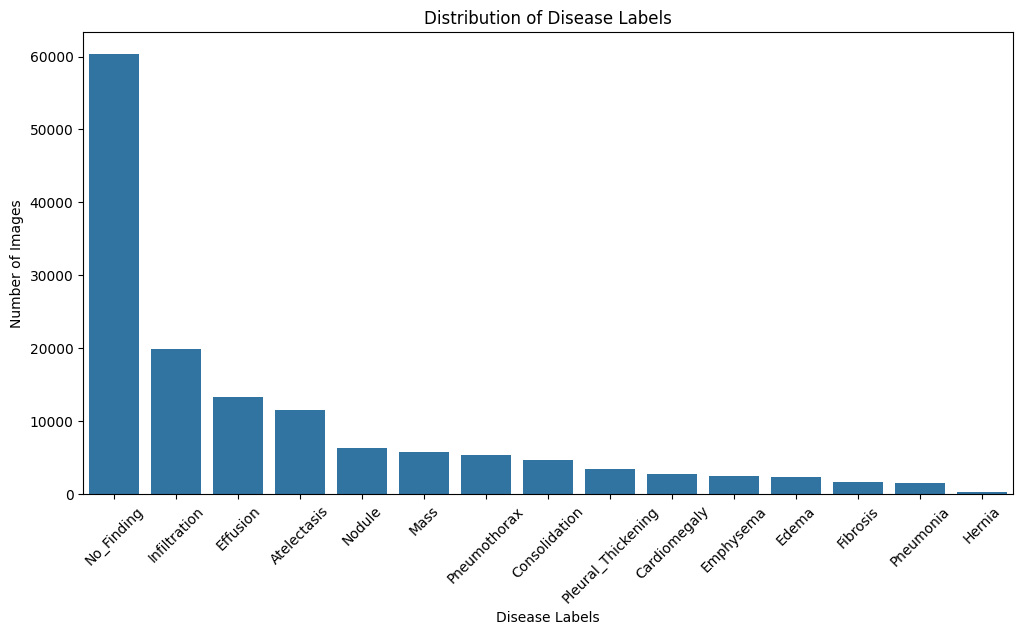

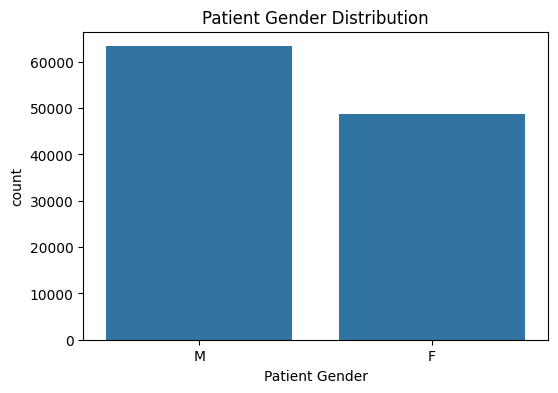

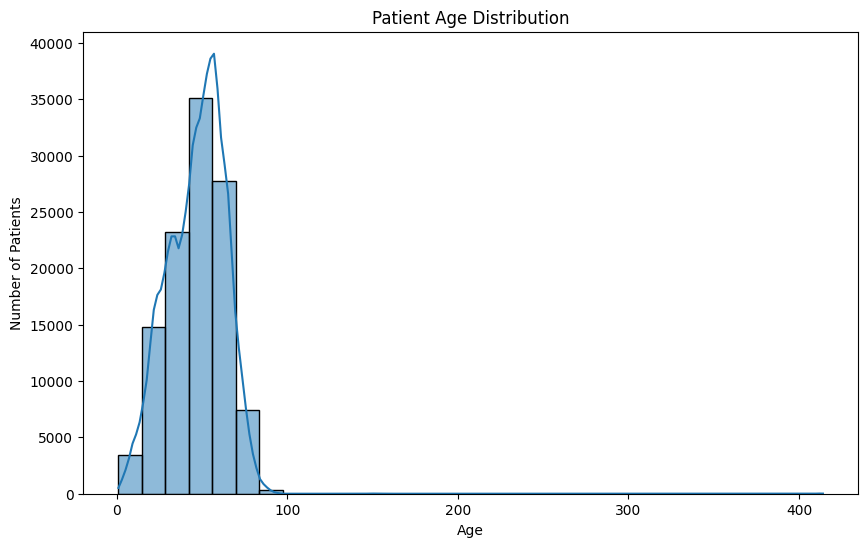

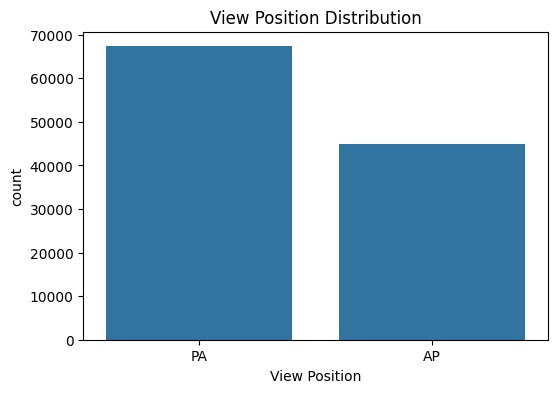

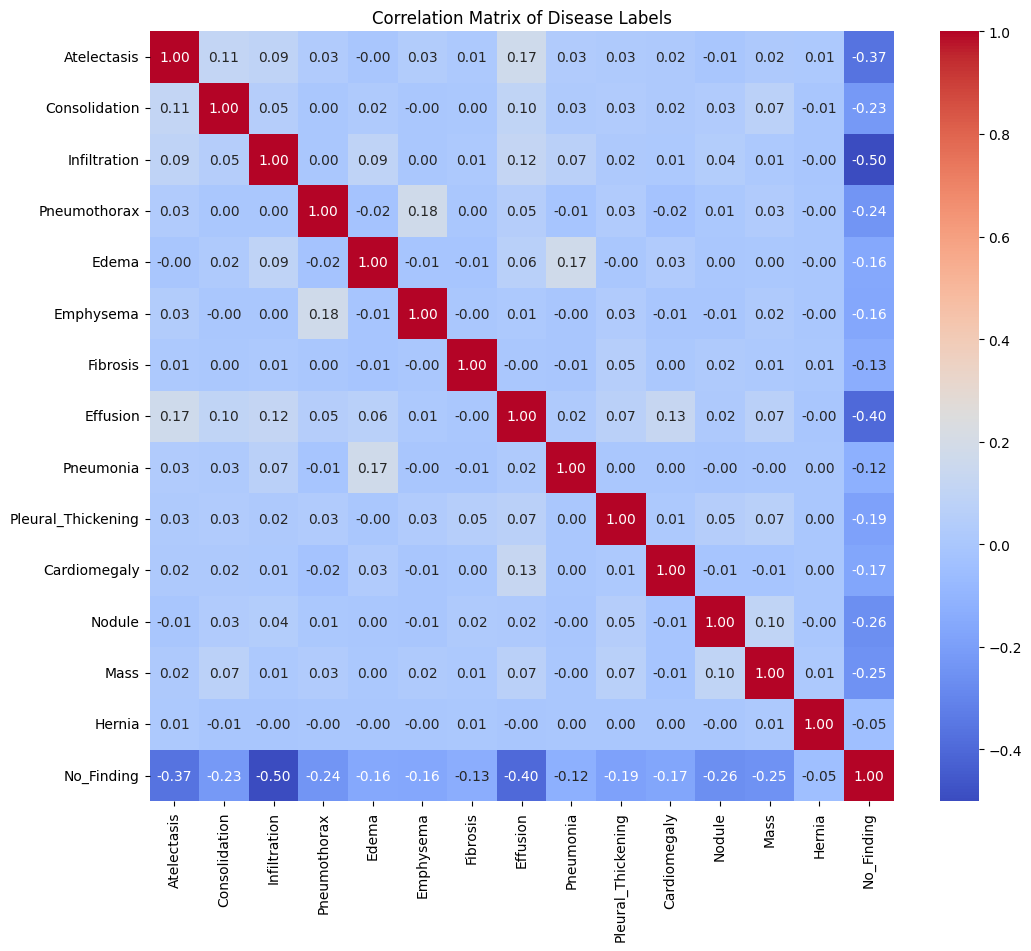

In [39]:
# Number of Unique Patients
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

# Label Distribution
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels")
plt.ylabel("Number of Images")
plt.xlabel("Disease Labels")
plt.show()

# Patient Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=labels_df)
plt.title("Patient Gender Distribution")
plt.show()

# Patient Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.show()

# View Position Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=labels_df)
plt.title("View Position Distribution")
plt.show()

# Correlation Matrix for Labels
plt.figure(figsize=(12, 10))
sns.heatmap(labels_df[disease_labels + ['No_Finding']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Disease Labels")
plt.show()

# **Step 5: Split Dataset**

In [40]:
# Get Unique Patient IDs
unique_patients = labels_df['Patient ID'].unique()

# Split Patients into Train+Val and Test (80-20)
train_val_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

# Create DataFrames
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


In [41]:
import fastai
from fastai.vision.all import *

item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Path']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [42]:
from fastai.vision.all import *
import torch
from torchvision.models import swin_v2_t, Swin_V2_T_Weights

# Step 1: Instantiate the Swin Transformer Tiny model with pretrained weights
model = swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)

# Step 2: Modify the final layer to match the number of classes in your dataset
# Assume 'dls' is your DataLoaders object
num_classes = dls.c  # Number of classes
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Step 3: Define callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
]

# Step 4: Create the Fastai Learner with the custom model
learn = Learner(
    dls,
    model,
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=ShowGraphCallback,
    wd=0.001
)

# Optional: Wrap the model with DataParallel for multi-GPU training
learn.model = torch.nn.DataParallel(learn.model)

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-11-21 22:42:03.383741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 22:42:03.397832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732225323.413225 2515759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732225323.417777 2515759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 22:42:03.433958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  8


# **Step 5: Build the Model**

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

intial learning rate= 0.0003311311302240938


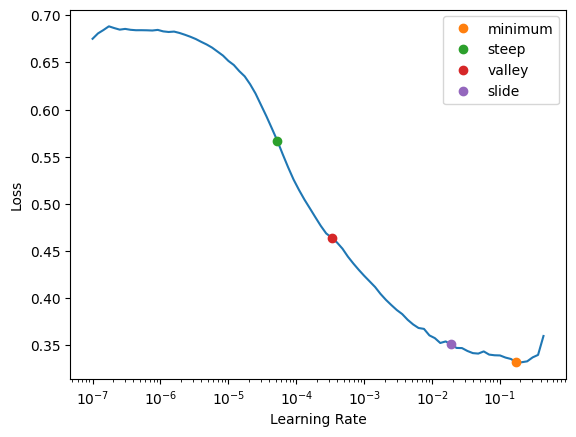

In [44]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [45]:
class PrintBatchProgressCallback(Callback):
    def before_epoch(self):
        print(f"Starting epoch {self.epoch+1}/{self.n_epoch}")

    def before_batch(self):
        total_batches = len(self.dls.train)
        print(f"Processing batch {self.iter+1}/{total_batches} in epoch {self.epoch+1}/{self.n_epoch}", end="\r")

    def after_epoch(self):
        print(f"\nFinished epoch {self.epoch+1}/{self.n_epoch}")

# Use the callback while fine-tuning
learn.fine_tune(
    freeze_epochs=3, 
    epochs=10, 
    base_lr=lrs.valley, 
    cbs=[PrintBatchProgressCallback()]
)

# **Step 6: Train the Model**

# **Step 7: Evaluate the Model**

In [ ]:
# TODO